In [2]:
# 加载相应的包，读取数据
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

%matplotlib inline

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# 将数组创建为10维二进制向量
# Images维数中第一维表示数据量，第二维784表示将28*28像素的图形完全展开
# Labels维数中第一维表示数据量，第二维10表示10个分类，例如，数字3的分类的Labels	为[0,0,0,1,0,0,0,0,0,]

trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels 

ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]
print( "Train Images: ", trainimgs.shape)
print( "Train Labels  ", trainlabels.shape)
print( "Test Images:  " , testimgs.shape)
print( "Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)
Test Images:   (10000, 784)
Test Labels:   (10000, 10)


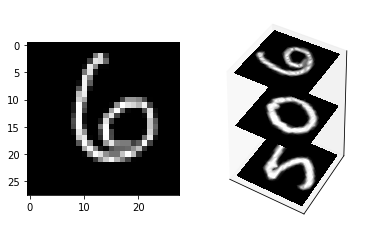

Sample: 100 - Class: [6] - Label Vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] 
Sample: 101 - Class: [0] - Label Vector: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 
Sample: 102 - Class: [5] - Label Vector: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.] 


In [5]:
# 查看MNIST数据集结构

samplesIdx = [100, 101, 102]  #<-- Y您可以在这里更改这些数字以查看其他样本

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[samplesIdx[0]].reshape([28,28]), cmap='gray')

xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)

img = testimgs[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))


offset=200
for i in samplesIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100

    ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

for i in samplesIdx:
    print( "Sample: {0} - Class: {1} - Label Vector: {2} "
          .format(i, np.nonzero(testlabels[i])[0], testlabels[i]))

In [6]:
# 设置RNN参数
# 此处的RNN由以下组成：
# 一个可以将 28∗28 维的输入转化为 128*128 维隐藏层的输入层
# 一个中间循环神经网络（LSTM）
# 一个可以将 128*128 维的LSTM输出转化为 10*10 维代表类标签输出的输出层

n_input = 28 # 输出MNIST数据 (img shape: 28*28)
n_steps = 28 # 时间步长
n_hidden = 128 # 隐藏层的特征
n_classes = 10 # MNIST全部的类(0-9 digits)

learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10000

In [7]:
# 构建一个递归网络，设置权重偏差

x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x") # 当前数据输入形状: (batch_size, n_steps, n_input) [100x28x28]
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [8]:
# 用TensorFlow定义一个lstm单元
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

In [9]:
# 创建一个从 lstm_cell指定的循环神经网络
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)

In [10]:
# 设置RNN输出矩阵
# RNN的输出将是一个[100x28x128]矩阵。我们使用线性激活将其映射到 [?x10 matrix]

output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
pred = tf.matmul(output, weights['out']) + biases['out']

In [11]:
# 定义成本函数，优化器，设置准确性和评估方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# 开始训练

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # 保持循环，直到最大次数迭代
    while step * batch_size < training_iters:

        # 我们将以batch_x的形式读取一批100张[100 x 784]图像
        # batch_y  是一个[100x10]的矩阵
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # 我们将图像的每一行视为一个序列
        # 重塑数据以获得28个元素的28个序列，因此，batxh_x是[100x28x28]
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    

        # 运行优化操作
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        
        if step % display_step == 0:
            # 计算批次精度
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # 计算批量损失
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # 计算128个mnist测试图像的准确性
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))
sess.close()

Optimization Finished!
Testing Accuracy: 0.976563
